In [136]:
#load libraries

from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

# set the environment path to find Recommenders
import sys
sys.path.append("../../")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import papermill as pm

from reco_utils.recommender.rbm.rbm import RBM
from reco_utils.dataset.python_splitters import numpy_stratified_split
from reco_utils.dataset.sparse import AffinityMatrix


from reco_utils.dataset import movielens
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

#For interactive mode only
%load_ext autoreload
%autoreload 2

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
System version: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Pandas version: 0.25.3


In [137]:
data = pd.read_csv('snackratings.csv', usecols=["userID", "itemID", "rating"])
data.head()

,userID,itemID,rating
0,1,3342,5
1,1,7522,1
2,1,25363,2
3,1,38997,5
4,1,43685,1


In [138]:
data.shape

(5000, 3)

In [139]:

# Convert to 32-bit in order to reduce memory consumption 
data.loc[:, 'rating'] = data['rating'].astype(np.int32) 

In [140]:
#to use standard names across the analysis 
header = {
        "col_user": "userID",
        "col_item": "itemID",
        "col_rating": "rating",
    }
#instantiate the sparse matrix generation  
am = AffinityMatrix(DF = data, **header)

#obtain the sparse matrix 
X = am.gen_affinity_matrix()

In [141]:
Xtr, Xtst = numpy_stratified_split(X)

In [142]:
print('train matrix size', Xtr.shape)
print('test matrix size', Xtst.shape)

train matrix size (500, 4023)
test matrix size (500, 4023)


In [143]:
#First we initialize the model class
model = RBM(hidden_units= 600, training_epoch = 10, minibatch_size= 60, keep_prob=0.9,with_metrics =True)

Device mapping:



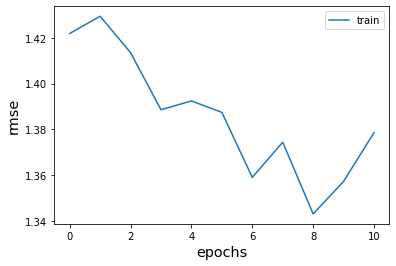

In [144]:
#Model Fit
train_time= model.fit(Xtr, Xtst)

In [145]:
#number of top score elements to be recommended  
K = 10

#Model prediction on the test set Xtst. 
top_k, test_time =  model.recommend_k_items(Xtst)

In [146]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [147]:
top_k_df.head(10)

,userID,itemID,prediction
0,1,70128,4.952920
1,1,75173,4.954018
2,1,135206,4.958278
3,1,120347,4.986495
4,1,27317,4.973076
5,1,35248,4.976043
6,1,125219,4.973897
7,1,99989,4.972112
8,1,55655,4.979995
9,1,105886,4.955644


In [148]:
test_df.head(10)

,userID,itemID,rating
0,1,7522,1
1,1,122506,3
2,2,134626,2
3,2,132216,2
4,3,86558,1
5,3,36412,1
6,4,128803,3
7,4,70128,3
8,5,24427,4
9,5,128621,4


In [149]:
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    time_train,
    time_test,
    K
):

    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)

    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)

    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)

    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)

    
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
            "Train time (s)": time_train,
            "Test time (s)": time_test
        }, 
        index=[0]
    )
    
    return df_result

In [150]:
eval= ranking_metrics(
    data_size = "mv 100k",
    data_true =test_df,
    data_pred =top_k_df,
    time_train=train_time,
    time_test =test_time,
    K =10)

eval

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k,Train time (s),Test time (s)
0,mv 100k,10,0.456381,0.532265,0.115,0.575,73.264525,22.8909


In [151]:
import scrapbook as sb

# Record results with papermill for tests
sb.glue("map", eval['MAP'][0])
sb.glue("ndcg", eval['nDCG@k'][0])
sb.glue("precision", eval['Precision@k'][0])
sb.glue("recall", eval['Recall@k'][0])
sb.glue("train_time", train_time)
sb.glue("test_time", test_time)

In [152]:
top_k_df.to_csv('RBM.csv')

In [153]:
data = pd.read_csv('RBM.csv', index_col = 0)
data.head()

,userID,itemID,prediction
0,1,70128,4.952920
1,1,75173,4.954018
2,1,135206,4.958278
3,1,120347,4.986495
4,1,27317,4.973076


In [156]:
p = data.loc[(data['userID'] == 1) & (data['itemID'] == 70128), 'prediction']

In [157]:
print(p)

0    4.95292
Name: prediction, dtype: float64
